<a href="https://colab.research.google.com/github/Abhi-1114/322MR-project-28/blob/main/Final_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install yfinance beautifulsoup4 lxml

In [3]:
# Imports & helper functions
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
%matplotlib inline

plt.rcParams['figure.figsize'] = (12,5)

def download_stock_data(ticker, start='2010-01-01'):
    """
    Download historical stock data using yfinance.
    Returns a dataframe with Date as a column (not index).
    """
    ticker_obj = yf.Ticker(ticker)
    df = ticker_obj.history(start=start)
    if df.empty:
        raise RuntimeError(f"No data returned for {ticker}. Check ticker or network.")
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def scrape_macrotrends_revenue(url):
    """
    Scrape the revenue table from a Macrotrends 'revenue' page.
    Returns DataFrame with Date (datetime) and Revenue (numeric, USD).
    """
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    resp = requests.get(url, headers=headers, timeout=15)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')
    tables = soup.find_all('table')
    # Find table that contains 'Revenue' in a header cell
    target_table = None
    for table in tables:
        th = table.find('th')
        if th and 'Revenue' in th.get_text():
            target_table = table
            break
    if target_table is None:
        # fallback: choose the largest table by rows
        target_table = max(tables, key=lambda t: len(t.find_all('tr'))) if tables else None
    if target_table is None:
        raise RuntimeError("Couldn't find any table on the page.")

    rows = []
    for tr in target_table.find_all('tr'):
        cols = [td.get_text(strip=True) for td in tr.find_all(['th','td'])]
        if cols:
            rows.append(cols)
    df = pd.DataFrame(rows[1:], columns=rows[0])  # header row -> columns

    # Identify the Date and Revenue columns (case-insensitive)
    col_map = {c.lower(): c for c in df.columns}
    date_col = col_map.get('date')
    revenue_col = None
    for c in df.columns:
        if 'revenue' in c.lower():
            revenue_col = c
            break
    if date_col is None or revenue_col is None:
        raise RuntimeError("Expected columns 'Date' and 'Revenue' not found in scraped table.")

    df = df[[date_col, revenue_col]].copy()
    df.columns = ['Date', 'Revenue']

    # Clean revenue values: remove '$' and ',' and convert to numeric
    df['Revenue'] = df['Revenue'].str.replace(r'[$,]', '', regex=True).replace('', np.nan)
    df['Revenue'] = pd.to_numeric(df['Revenue'], errors='coerce')
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Drop missings and sort ascending by Date
    df = df.dropna(subset=['Date', 'Revenue']).sort_values('Date').reset_index(drop=True)
    return df

In [4]:
# Download TSLA and GME historical stock data
tesla_data = download_stock_data('TSLA', start='2010-01-01')
gme_data   = download_stock_data('GME',  start='2005-01-01')

print("Tesla rows:", len(tesla_data))
print("GameStop rows:", len(gme_data))

Tesla rows: 3938
GameStop rows: 5319


In [5]:
# Macrotrends revenue pages (these are the usual pages used in the lab)
tesla_revenue_url = 'https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue'
gme_revenue_url   = 'https://www.macrotrends.net/stocks/charts/GME/gamestop/revenue'

tesla_revenue = scrape_macrotrends_revenue(tesla_revenue_url)
gme_revenue   = scrape_macrotrends_revenue(gme_revenue_url)

print("Tesla revenue rows:", len(tesla_revenue))
print("GameStop revenue rows:", len(gme_revenue))

HTTPError: 403 Client Error: Forbidden for url: https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue

In [6]:
# 1.1 First five rows of tesla_data
print("=== Tesla stock (first 5 rows) ===")
display(tesla_data.head())

# 1.2 Last five rows of tesla_revenue
print("=== Tesla revenue (last 5 rows) ===")
display(tesla_revenue.tail())

# 1.3 First five rows of gme_data
print("=== GameStop stock (first 5 rows) ===")
display(gme_data.head())

# 1.4 Last five rows of gme_revenue
print("=== GameStop revenue (last 5 rows) ===")
display(gme_revenue.tail())

=== Tesla stock (first 5 rows) ===


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


=== Tesla revenue (last 5 rows) ===


NameError: name 'tesla_revenue' is not defined

NameError: name 'tesla_revenue' is not defined

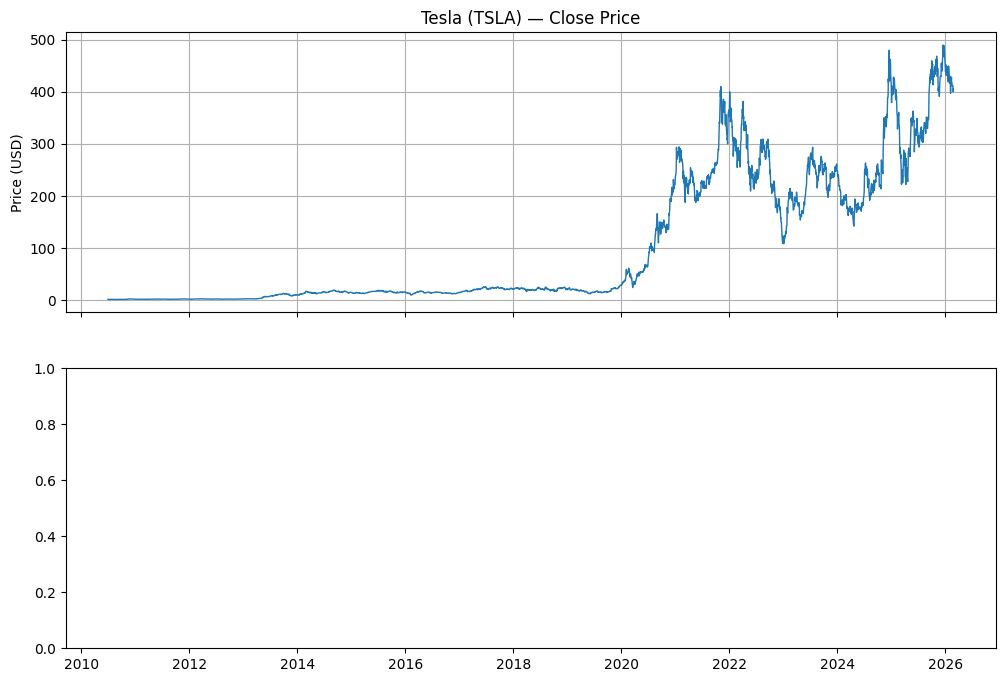

In [7]:
# Plot Tesla Close price and Revenue
fig, axes = plt.subplots(2,1,sharex=True, figsize=(12,8))

axes[0].plot(tesla_data['Date'], tesla_data['Close'], lw=1)
axes[0].set_title('Tesla (TSLA) — Close Price')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True)

axes[1].plot(tesla_revenue['Date'], tesla_revenue['Revenue'], marker='o', lw=1)
axes[1].set_title('Tesla — Revenue')
axes[1].set_ylabel('Revenue (USD)')
axes[1].grid(True)

axes[1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'gme_revenue' is not defined

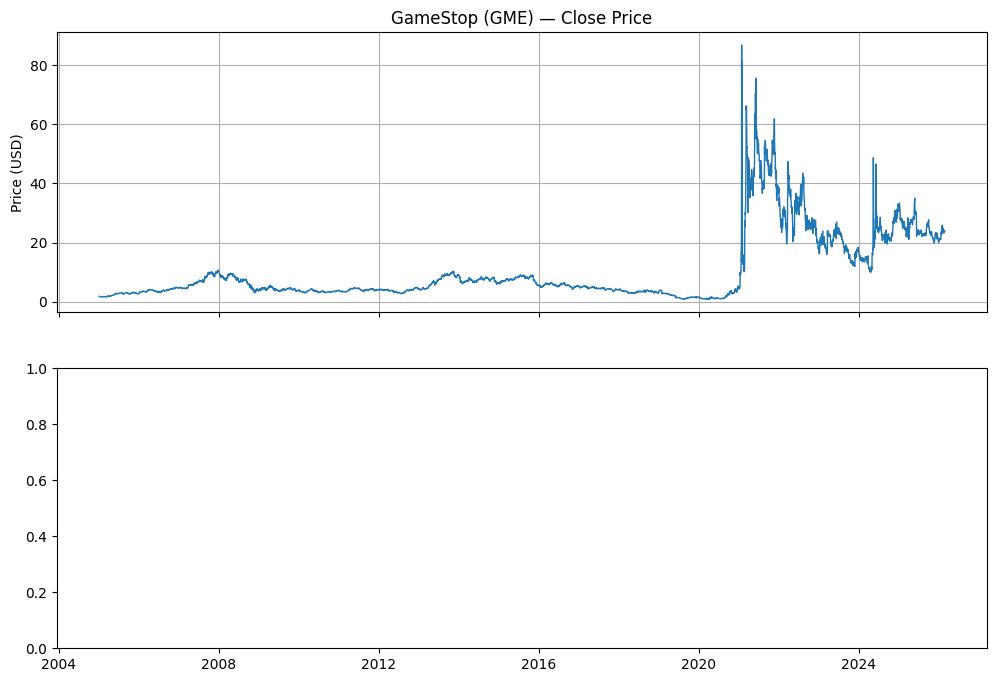

In [8]:
# Plot GameStop Close price and Revenue
fig, axes = plt.subplots(2,1,sharex=True, figsize=(12,8))

axes[0].plot(gme_data['Date'], gme_data['Close'], lw=1)
axes[0].set_title('GameStop (GME) — Close Price')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True)

axes[1].plot(gme_revenue['Date'], gme_revenue['Revenue'], marker='o', lw=1)
axes[1].set_title('GameStop — Revenue')
axes[1].set_ylabel('Revenue (USD)')
axes[1].grid(True)

axes[1].xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()